In [23]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, IsochronePotential, PowerSphericalPotential, MiyamotoNagaiPotential
from galpy.util import bovy_conversion
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from galpy.potential import IsochronePotential
from scipy.signal import find_peaks

# Prva naloga

<Figure size 600x600 with 0 Axes>

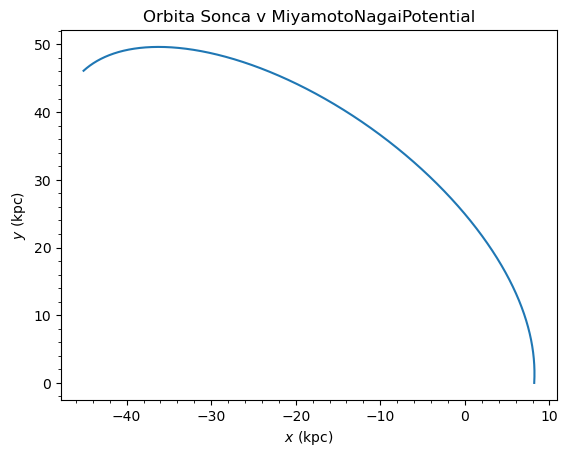

In [38]:
# Sun parameters
R0 = 8.2 * u.kpc           # razdalja Sonca od središča Galaksije
V0 = 232 * u.km/u.s        # krožilna hitrost Sonca
z0 = 0.025 * u.kpc         # višina Sonca nad galaktično ravnino
vz0 = 7.25 * u.km/u.s      # navpična hitrost
vr0 = 11.1 * u.km/u.s      # radialna hitrost (proti središču)
vT0 = V0 + 12.24 * u.km/u.s  # tangencialna hitrost (rotacija + solarni prirastek)

o = Orbit(vxvv=[R0, vr0, vT0, z0, vz0, 0*u.deg], ro=R0, vo=V0)
ts = np.linspace(0, 1, 10000) * u.Gyr


o.integrate(ts, MiyamotoNagaiPotential())
plt.figure(figsize = (6,6))
o.plot(d1='x', d2='y')
plt.title('Orbita Sonca v MiyamotoNagaiPotential')
plt.show()

In [3]:
# --- Izračun in izpis parametrov ---
rperi = o.rperi()
rap = o.rap()
ecc = o.e()

print(f"Pericenter: {rperi:.2f}")
print(f"Apocenter:  {rap:.2f}")
print(f"Ekscentričnost: {ecc:.3f}")

Pericenter: 8.12
Apocenter:  9.33
Ekscentričnost: 0.069


# Druga naloga

<Figure size 700x700 with 0 Axes>

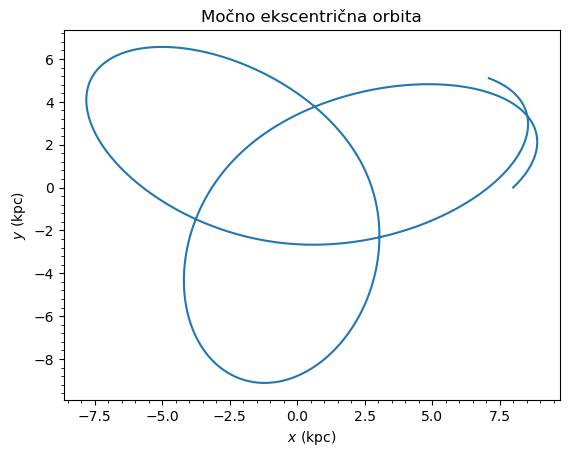

In [33]:
# Močno ekscentrična orbita
o1 = Orbit(vxvv=[8*u.kpc, 100*u.km/u.s, 120*u.km/u.s, 0*u.kpc, 0*u.km/u.s, 0*u.deg])
ts = np.linspace(0, 0.4, 10000) * u.Gyr
o1.integrate(ts, MWPotential2014)

plt.figure(figsize=(7,7))
o1.plot(d1='x', d2='y')
plt.title("Močno ekscentrična orbita")
plt.show()

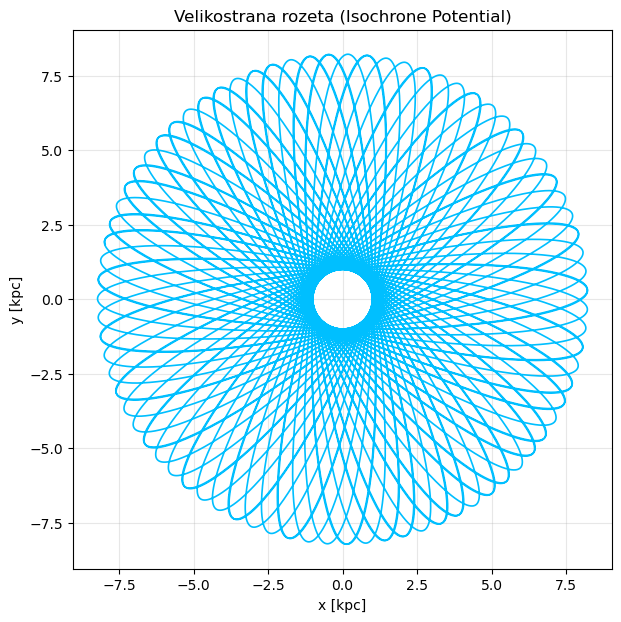

In [30]:
# Potential: soft, spherical -> smooth rosette patterns
pot = IsochronePotential(b=0.8, normalize=1.0)

# Orbit tuned for ~3 radial oscillations per 2 rotations (3-lobed rosette)
o = Orbit(vxvv=[1.0*u.kpc, 0*u.km/u.s, 1.28*220*u.km/u.s, 0*u.kpc, 0*u.km/u.s, 0*u.deg])

# Time grid
ts = np.linspace(0, 12, 30000) * u.Gyr

# Integrate orbit
o.integrate(ts, pot)

# Extract position (unit-safe)
x = o.x(ts)
y = o.y(ts)
if hasattr(x, "to"):
    x = x.to(u.kpc).value
if hasattr(y, "to"):
    y = y.to(u.kpc).value

# Plot
plt.figure(figsize=(7,7))
plt.plot(x, y, lw=1.2, color='deepskyblue')
plt.gca().set_aspect('equal', 'box')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Velikostrana rozeta (Isochrone Potential)')
plt.grid(True, alpha=0.3)
plt.show()


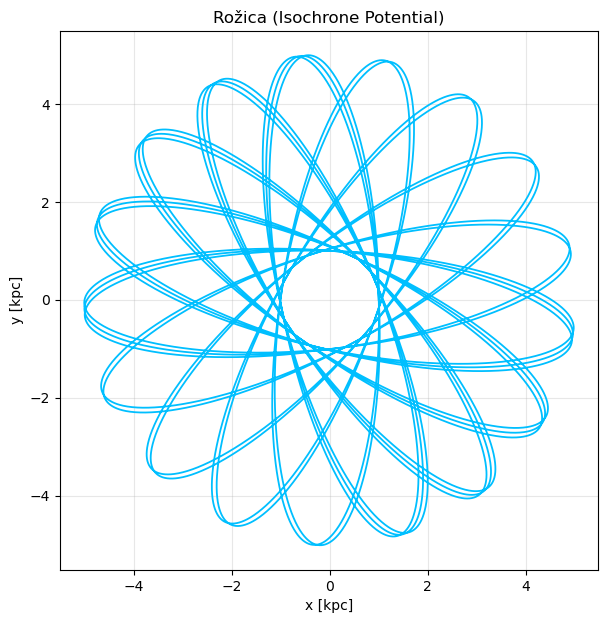

In [ ]:
# Smooth, nearly Keplerian potential
pot = IsochronePotential(b=0.5, normalize=1.0)

# Fine-tuned tangential velocity for 3:2 resonance
o = Orbit(vxvv=[1.0*u.kpc, 0*u.km/u.s, 1.15*220*u.km/u.s, 0*u.kpc, 0*u.km/u.s, 0*u.deg])

# Integrate for a shorter time so it doesn’t over-precess
ts = np.linspace(0, 3, 15000) * u.Gyr

o.integrate(ts, pot)

x = o.x(ts)
y = o.y(ts)
if hasattr(x, "to"):
    x = x.to(u.kpc).value
if hasattr(y, "to"):
    y = y.to(u.kpc).value

plt.figure(figsize=(7,7))
plt.plot(x, y, lw=1.3, color="deepskyblue")
plt.gca().set_aspect("equal", "box")
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.title("Rožica (Isochrone Potential)")
plt.grid(True, alpha=0.3)
plt.show()

Chosen vT ≈ 210.1 km / s, n_rad/n_azi ≈ 12.734


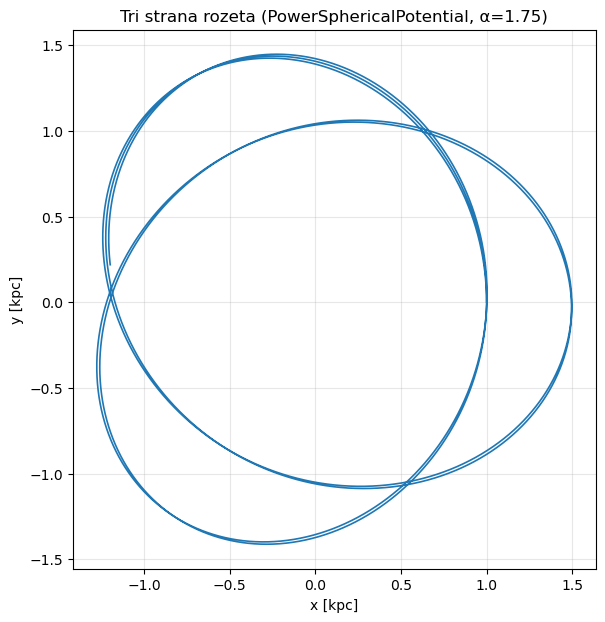

In [32]:
# Target: vc ∝ R^β with β ≈ 0.125  →  PowerSphericalPotential with α = 1.75
pot = PowerSphericalPotential(alpha=1.75, normalize=1.0)

tGyr = 0.2

def integrate(o, t=tGyr, n=30000):
    ts = np.linspace(0, t, n) * u.Gyr
    o.integrate(ts, pot)
    return ts

def count_radial_and_azimuthal(o, ts):
    R = o.R(ts); phi = o.phi(ts)
    R = R.value if hasattr(R, "value") else np.asarray(R)
    phi = phi.to(u.rad).value if hasattr(phi, "to") else np.asarray(phi)
    # count radial minima
    peaks, _ = find_peaks(-R)
    n_rad = len(peaks)
    dphi = phi[-1] - phi[0]
    n_azi = dphi/(2*np.pi)
    return n_rad, n_azi

# sweep vT around circular speed (vo=220 km/s in galpy’s defaults)
R0 = 1.0 * u.kpc
vR0 = 0.0 * u.km/u.s
vTs = (np.linspace(0.85, 1.15, 41) * 220) * u.km/u.s  # try ±15%

best = None
for vT in vTs:
    o = Orbit([R0, vR0, vT, 0*u.kpc, 0*u.km/u.s, 0*u.deg])
    ts = integrate(o, t=tGyr, n=30000)
    n_rad, n_azi = count_radial_and_azimuthal(o, ts)
    if n_rad < 4: 
        continue
    ratio = (n_rad / max(n_azi, 1e-6))
    err = abs(ratio - 3/2)/(3/2)
    if (best is None) or (err < best["err"]):
        best = dict(o=o, ts=ts, vT=vT, ratio=ratio, err=err, n_rad=n_rad, n_azi=n_azi)

print(f"Chosen vT ≈ {best['vT']:.1f}, n_rad/n_azi ≈ {best['ratio']:.3f}")

# Plot the orbit
x = best["o"].x(best["ts"]); y = best["o"].y(best["ts"])
x = x.to(u.kpc).value if hasattr(x, "to") else np.asarray(x, float)
y = y.to(u.kpc).value if hasattr(y, "to") else np.asarray(y, float)

plt.figure(figsize=(7,7))
plt.plot(x, y, lw=1.2)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('x [kpc]'); plt.ylabel('y [kpc]')
plt.title('Tri strana rozeta (PowerSphericalPotential, α=1.75)')
plt.grid(True, alpha=0.3)
plt.show()